In [635]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_predict, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Part 1

The data from Kaggle is pre-split into test and train.  I will be inheriting that as the data also provided in the github is appears to follow the same pre-split.

In [636]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [637]:
train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
590,591,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.125,NaN,S
117,118,0,2,"Turpin, Mr. William John Robert",male,29.0,1,0,11668,21.000,NaN,S
464,465,0,3,"Maisner, Mr. Simon",male,NaN,0,0,A/S 2816,8.050,NaN,S


In [638]:
test.sample(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
350,1242,1,"Greenfield, Mrs. Leo David (Blanche Strouse)",female,45.0,0,1,PC 17759,63.3583,D10 D12,C
257,1149,3,"Niklasson, Mr. Samuel",male,28.0,0,0,363611,8.0500,NaN,S
166,1058,1,"Brandeis, Mr. Emil",male,48.0,0,0,PC 17591,50.4958,B10,C


### Null/Missing Values per column

In [639]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

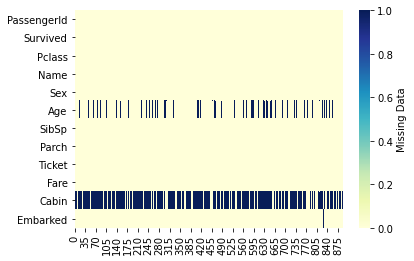

In [640]:
sns.heatmap(train.isna().transpose(), cmap="YlGnBu",cbar_kws={'label': 'Missing Data'});

In [641]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

survived, sex, and embarked are functionally categorical, but only Sex and Embarked are storred as a categorical object.  The columns could be encoded to be categorical if needed as well as Pclass, SibSp, and Parch could be used as categorical if desired.

### Total Men v.s. Women Count of Survival

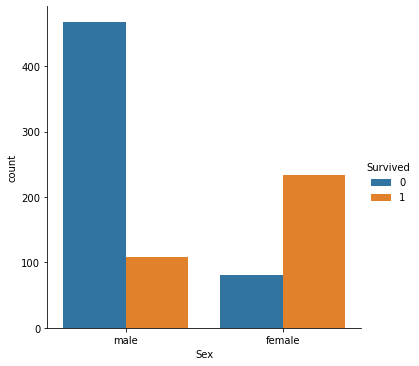

In [642]:
sns.catplot(x='Sex', hue='Survived', kind='count', data=train);

We are able to observe that in aggregate, more men died than women.

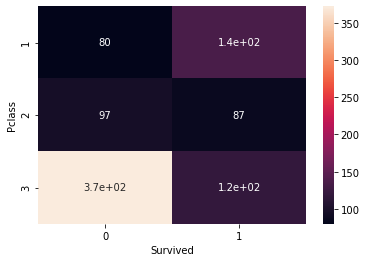

In [643]:
group = train.groupby(['Pclass', 'Survived']).size().unstack()
sns.heatmap(group, annot = True);

### Vanila Distribution

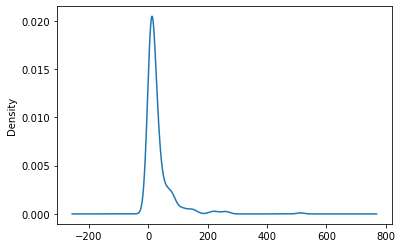

In [644]:
train['Fare'].plot.density();

### Binned and observed with Survived

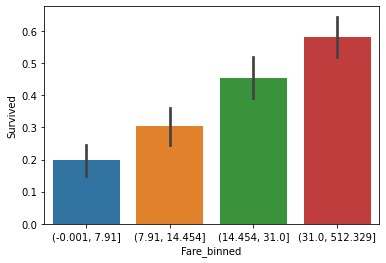

In [645]:
train['Fare_binned'] = pd.qcut(train['Fare'], 4)
sns.barplot(x ='Fare_binned', y ='Survived', data = train);

### Age Observed Against Sex and Survival

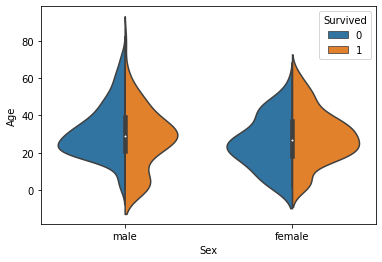

In [646]:
sns.violinplot(x ="Sex", y ="Age", hue ="Survived", data = train, split = True);

In [647]:
age_grouped = train.groupby(['Pclass']).median('Age')

### Median Age of Each Passenger Class

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

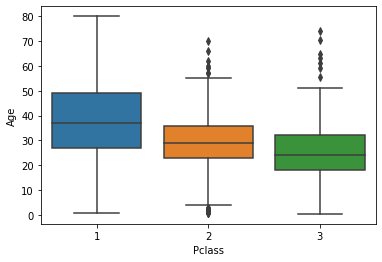

In [648]:
sns.boxplot(x='Pclass', y='Age',  data=train)

In [649]:
#Numeric validation
age_grouped['Age']

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

# Part 2

### Removing Cabin

In [650]:
##Only run this once - need to stop forgetting about the state
train.drop(columns='Cabin', inplace=True)
test.drop(columns='Cabin', inplace=True)

### Funciton for Imputing Age

In [651]:
## quick fix for indexing easily on the med age
age_grouped.index=age_grouped.index.astype(int)

### Function for null age
def impute_age(row):
    if pd.isna(row['Age']):
        #print(row['Pclass'])
        row['Age'] = age_grouped['Age'].iloc[int(row['Pclass'])-1] #hacky, but works
    return row
    

In [652]:
train[['Age', 'Pclass']] = train[['Age', 'Pclass']].apply(impute_age, axis=1)

### First Check for Nulls

In [653]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
Fare_binned    0
dtype: int64

In [654]:
train = train.dropna()

In [655]:
### Secoond Check for Nulls

In [656]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Fare_binned    0
dtype: int64

### Dummy Variables

In [657]:
train = pd.concat([pd.get_dummies(train['Sex']), train], axis=1)

In [658]:
train = pd.concat([pd.get_dummies(train['Embarked'], prefix="Embarked"), train], axis=1)

### Dropping Noise

In [659]:
survived = train['Survived']
train.drop(columns=['Survived'], inplace=True)

In [660]:
train.drop(columns=['Name', 'Ticket', 'PassengerId', 'Sex','Embarked', 'Fare_binned' ], inplace=True)

In [661]:
train.sample(3)

,Embarked_C,Embarked_Q,Embarked_S,female,male,Pclass,Age,SibSp,Parch,Fare
263,0,0,1,0,1,1.0,40.0,0,0,0.00
314,0,0,1,0,1,2.0,43.0,1,1,26.25
874,1,0,0,1,0,2.0,28.0,1,0,24.00


# Part 3

## Logistic Regression

In [662]:
logistic = LogisticRegression(max_iter=1000)
logistic.fit(train, survived)
log_prob = logistic.predict_proba(train)
log_prob = log_prob[:,1]
#log_auc = roc_auc_score(train, log_prob)
log_fp, log_tp, log_thresh = roc_curve(survived, log_prob)
survived_hatlog = logistic.predict(train)

In [663]:
print(classification_report(survived , survived_hatlog))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       549
           1       0.77      0.71      0.74       340

    accuracy                           0.81       889
   macro avg       0.80      0.79      0.79       889
weighted avg       0.80      0.81      0.80       889



In [664]:
print(confusion_matrix(survived , survived_hatlog))

[[476  73]
 [100 240]]


#### Precision Vs Recall

In [665]:
log_prec, log_recall, log_thres = precision_recall_curve(survived, log_prob)

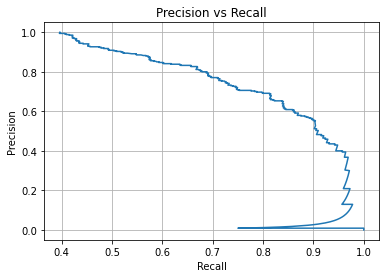

In [666]:
plt.plot(log_prec, log_recall)
plt.title('Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

In [667]:
# plt.plot(log_thres, log_prec[:-1], "b--", label='Precision')
# plt.plot(log_thres, log_recall[:-1], "g-", label="Recall")
# plt.xlabel('Probability')
# plt.legend()
# plt.show()

#### ROC Curve

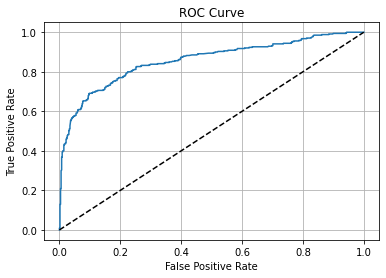

In [668]:
plt.plot(log_fp, log_tp)
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

## Support Vector Classifier

In [669]:
svc = LinearSVC(random_state=1, max_iter=1000000000)
svc.fit(train, survived)
survived_hatsvc = svc.predict(train)

In [670]:
print(classification_report(survived , survived_hatsvc))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       549
           1       0.77      0.70      0.73       340

    accuracy                           0.81       889
   macro avg       0.80      0.79      0.79       889
weighted avg       0.80      0.81      0.80       889



In [671]:
print(confusion_matrix(survived , survived_hatsvc))

[[478  71]
 [102 238]]


#### Precision Vs Recall

In [672]:
svc_yscores = svc.decision_function(train)

In [673]:
svc_prec, svc_recall, svc_thres = precision_recall_curve(survived, svc_yscores)

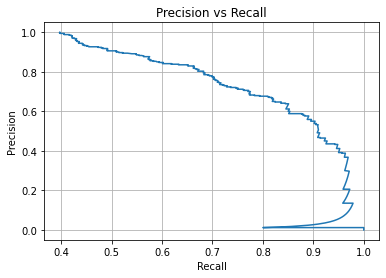

In [674]:
plt.plot(svc_prec, svc_recall)
plt.title('Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

In [675]:
# plt.plot(svc_thres, svc_prec[:-1], "b--", label='Precision')
# plt.plot(svc_thres, svc_recall[:-1], "g-", label="Recall")
# plt.xlabel('Threshold')
# plt.legend()
# plt.show()

#### ROC

In [676]:
svc_fp, svc_tp, svc_thres = roc_curve(survived, svc_yscores)

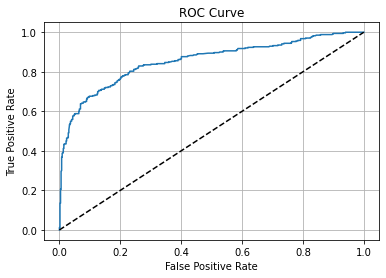

In [677]:
plt.plot(svc_fp, svc_tp)
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

## SGD Classifier

In [678]:
sgd = SGDClassifier(random_state=1)
sgd.fit(train, survived);
survived_hatsgd = sgd.predict(train)

In [679]:
print(classification_report(survived , survived_hatsgd))

              precision    recall  f1-score   support

           0       0.74      0.94      0.83       549
           1       0.82      0.46      0.59       340

    accuracy                           0.76       889
   macro avg       0.78      0.70      0.71       889
weighted avg       0.77      0.76      0.74       889



In [680]:
print(confusion_matrix(survived , survived_hatsgd))

[[515  34]
 [182 158]]


#### Precision Vs Recall

In [681]:
sgd_yscores = sgd.decision_function(train)

In [682]:
sgd_prec, sgd_recall, sgd_thres = precision_recall_curve(survived, sgd_yscores)

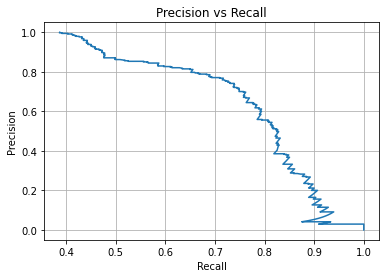

In [683]:
plt.plot(sgd_prec, sgd_recall)
plt.title('Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

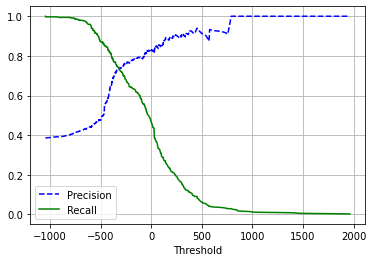

In [684]:
plt.plot(sgd_thres, sgd_prec[:-1], "b--", label='Precision')
plt.plot(sgd_thres,sgd_recall[:-1], "g-", label="Recall")
plt.xlabel('Threshold')
plt.grid()
plt.legend()
plt.show()

#### ROC

In [685]:
sgd_fp, sgd_tp, sgd_thres = roc_curve(survived, sgd_yscores)

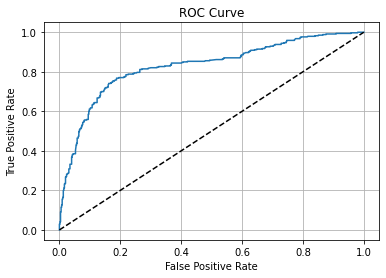

In [686]:
plt.plot(sgd_fp, sgd_tp)
plt.plot([0,1], [0,1], 'k--')
plt.grid()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Part 4

In class it was mentioned to use a linear SVC, so I used the pre-defined sklearn implementation above.  But to do the desired grid search, we have to use SVC and define the kernel. Just wanted to note why there is a difference.

In [687]:
svc_opt = Pipeline([
    ('scaler', StandardScaler()),
    ('svc2', SVC(random_state=1, max_iter=1000000000))
])

svc_opt.fit(train,survived);

In [688]:
grid = {'svc2__kernel': ['rbf'], 'svc2__gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'svc2__C': [1,10,50,100,200,300]}

grid_search = GridSearchCV(svc_opt, grid)
grid_search.fit(train, survived)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc2',
                                        SVC(max_iter=1000000000,
                                            random_state=1))]),
             param_grid={'svc2__C': [1, 10, 50, 100, 200, 300],
                         'svc2__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'svc2__kernel': ['rbf']})

In [689]:
#svc_opt.get_params().keys()

### Best Estimator

In [690]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc2',
                 SVC(C=50, gamma=0.01, max_iter=1000000000, random_state=1))])

### Best Parameters

In [691]:
grid_search.best_params_

{'svc2__C': 50, 'svc2__gamma': 0.01, 'svc2__kernel': 'rbf'}

In [692]:
svc2y_hat = grid_search.best_estimator_.predict(train)
print(classification_report(survived , svc2y_hat))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       549
           1       0.89      0.67      0.77       340

    accuracy                           0.84       889
   macro avg       0.86      0.81      0.82       889
weighted avg       0.85      0.84      0.84       889



In [693]:
print(confusion_matrix(survived , svc2y_hat))

[[520  29]
 [111 229]]


In [694]:
svc2_yscores = grid_search.best_estimator_.decision_function(train)
svc2_prec, svc2_recall, svc2_thres = precision_recall_curve(survived, svc2_yscores)

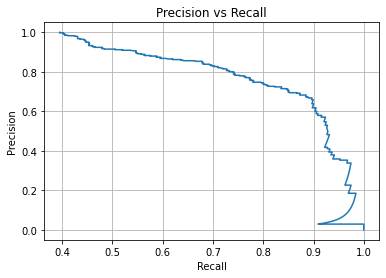

In [695]:
plt.plot(svc2_prec, svc2_recall)
plt.title('Precision vs Recall')
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [696]:
svc2_fp, svc2_tp, svc2_thres = roc_curve(survived, svc2_yscores)

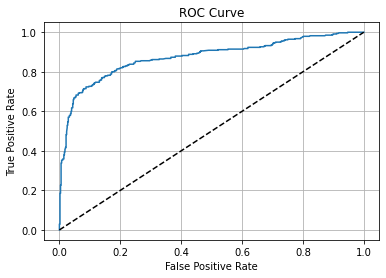

In [697]:
plt.plot(svc2_fp, svc2_tp)
plt.plot([0,1], [0,1], 'k--')
plt.grid()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Learning Curve

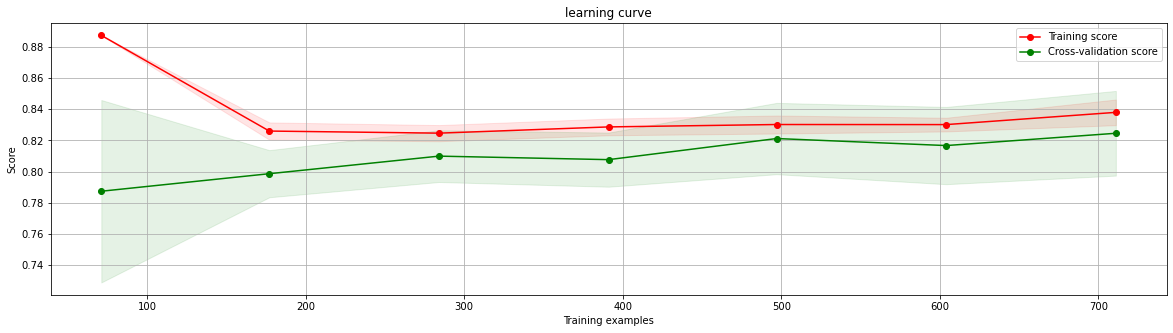

In [698]:
_, axes = plt.subplots(1, 1, figsize=(20, 5))
axes.set_title('learning curve')
axes.set_xlabel("Training examples")
axes.set_ylabel("Score")
axes.grid()
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(grid_search.best_estimator_, train, survived,  
                       train_sizes=np.linspace(.1, 1.0, 7),
                       return_times=True)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes.legend(loc="best")
plt.show();


The learning curve shows us that it may be costly to improve the estimator.  There does appear to be a trend improving scores as example increase, but the training score and cv score do not appear to be converging.  In the context of Titanic data, we may have the universe of examples and will likely need to look at other options to improve the model.  

As far as improved performance with scaling goes, the difference is negligible.  If we look at the classification report and confusion matrix, there isn't much of an improvement.  Depending on our tollerances, both models may need work.  